# Explore latest detections

In [1]:

import json
import pandas
import numpy
from matplotlib import pyplot

confidence_threshold = 0.4

In [2]:
def load_birdnet_log(path, confidence_threshold: float = 0.25) -> pandas.DataFrame:
    lines = [json.loads(s) for s in open(path)]
    raw = pandas.DataFrame.from_records(lines)

    raw = raw[raw['msg'] == 'success'].copy()
    raw = raw.explode(['results'])
    raw['timestamp'] = pandas.to_datetime(raw['timestamp'])

    raw[['name','confidence']] = pandas.DataFrame(raw.results.tolist(), index=raw.index)
    raw[['species', 'common']] = raw['name'].str.split("_", expand = True)
    raw.drop(columns=['msg', 'results', 'filename', 'oldest', 'name', 'skipped', 'hour_of_day'], inplace=True)
    return raw.query('confidence > @confidence_threshold', engine='python').copy()

raw = load_birdnet_log('logs/birdnet.log')

<Axes: ylabel='common'>

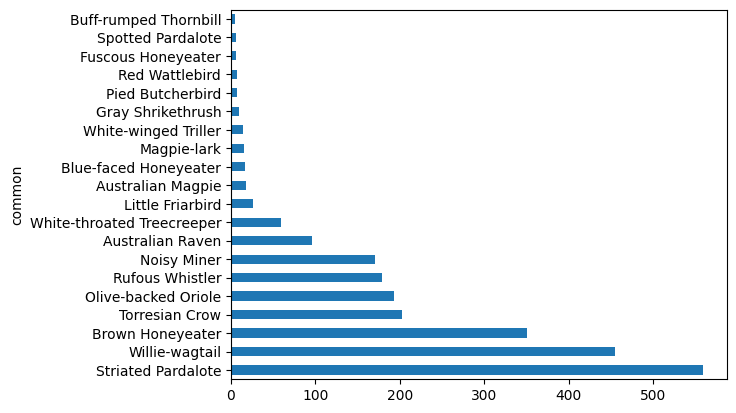

In [3]:
def barplot_species_frequency(
    data: pandas.DataFrame,
    legend_count: int = 20,
):
    df = data.query('confidence > @confidence_threshold', engine='python')
    # Plot top species
    ax = df.common.value_counts().nlargest(20).plot(kind='barh')
    return (ax, df)

ax, _ = barplot_species_frequency(raw)
ax

In [4]:
def roseplot_species_by_hour(
    data, 
    title: str,
    legend_count: int = 7,
):
    df = data.copy()

    top_species = (
        df
        .groupby('common')
        .size()
        .reset_index()
        .nlargest(legend_count, 0, keep='first')
    ).common.values

    # Replace species outside top_n with Other
    df.common = df.common.apply(lambda x: x if x in top_species else 'Other')
    # Count by hour
    species_by_hour = (
        df
        .assign(hod=lambda r: r['timestamp'].dt.hour)
        .groupby(by=['common', 'hod'])
        .size()
        .reset_index()
        .rename(columns={0: "count"})
        .sort_values(['hod', 'count'], ascending=[True, False])
    )

    # Transform and reorder
    plotdf = (
        species_by_hour
        .groupby(['hod', 'common'])
        .sum()
        .unstack(level=-1)
        .fillna(0)
        .reindex([h for h in range(0, 24)], fill_value=0.0)
        .reset_index(drop=True)
         # .drop(0, axis='columns')
    )
    plotdf.columns = plotdf.columns.get_level_values('common')
    other = plotdf.pop('Other')
    plotdf.insert(0, 'Other', other)

    hours = [h for h in range(0, 24)]
    hours24 = numpy.asarray([f"{_:02}:00" for _ in hours])

    N = len(hours)
    theta = numpy.linspace(0, 2*numpy.pi, N, endpoint=False)
    width = numpy.pi * 2 / N

    fig, ax = pyplot.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_title(title)
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(plotdf.columns[:-1], plotdf.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(theta, plotdf[c1].values, 
                    width=width,
                    # color=palette[0],
                    edgecolor='none',
                    label=c1,
                    linewidth=0)

        # all other columns
        ax.bar(theta, plotdf[c2].values, 
                width=width, 
                bottom=plotdf.cumsum(axis=1)[c1].values,
                # color=palette[n+1],
                edgecolor='none',
                label=c2,
                linewidth=0)

    leg = ax.legend(loc=(0.8, 0.95), ncol=2)
    ax.set_xticks(theta)
    xtl = ax.set_xticklabels(hours24)
    ax.annotate(max(raw.timestamp).strftime("%Y/%m/%d"), xy = (0, 0), xycoords='axes fraction')
    return fig

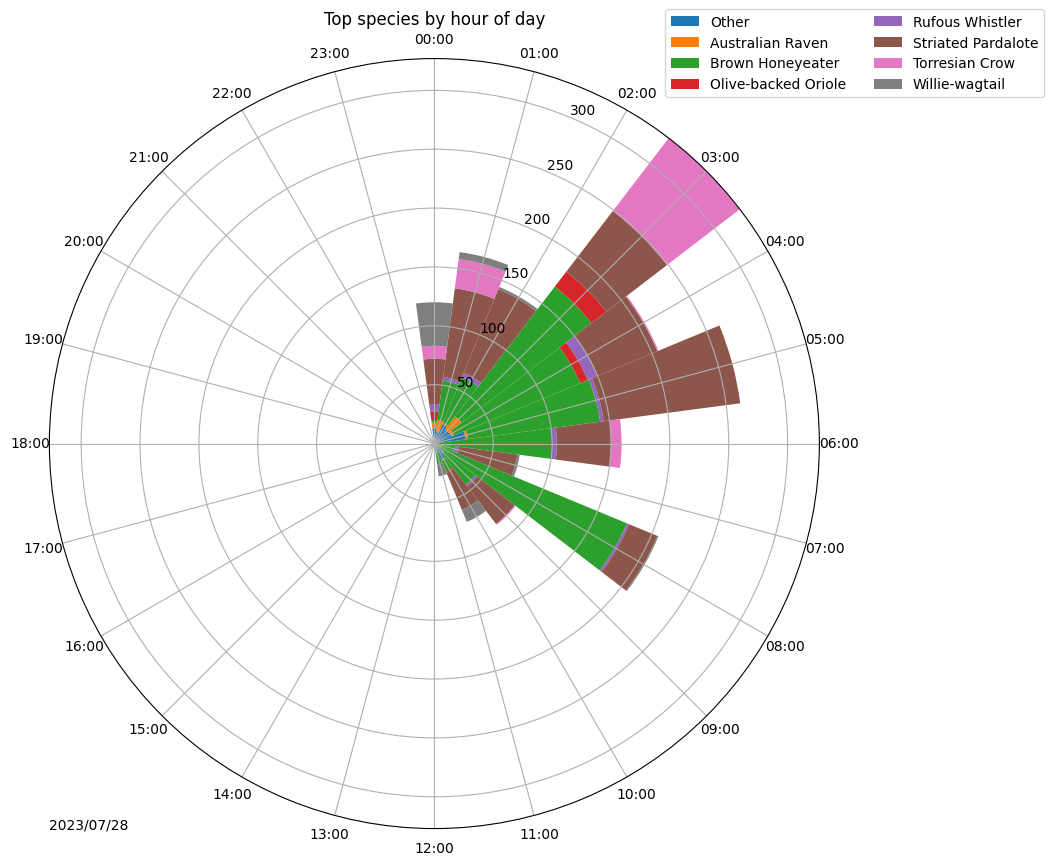

In [5]:
raw = load_birdnet_log('logs/birdnet.log.2023-07-28', confidence_threshold)
fig = roseplot_species_by_hour(raw, "Top species by hour of day")

## Last Hour

In [52]:
from datetime import datetime, timedelta
raw = load_birdnet_log('logs/birdnet.log.2023-07-28', confidence_threshold=0.4)

timestamp = datetime.fromisoformat("2023-07-28T07:00:00+10:00")
timestamp

datetime.datetime(2023, 7, 28, 7, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=36000)))

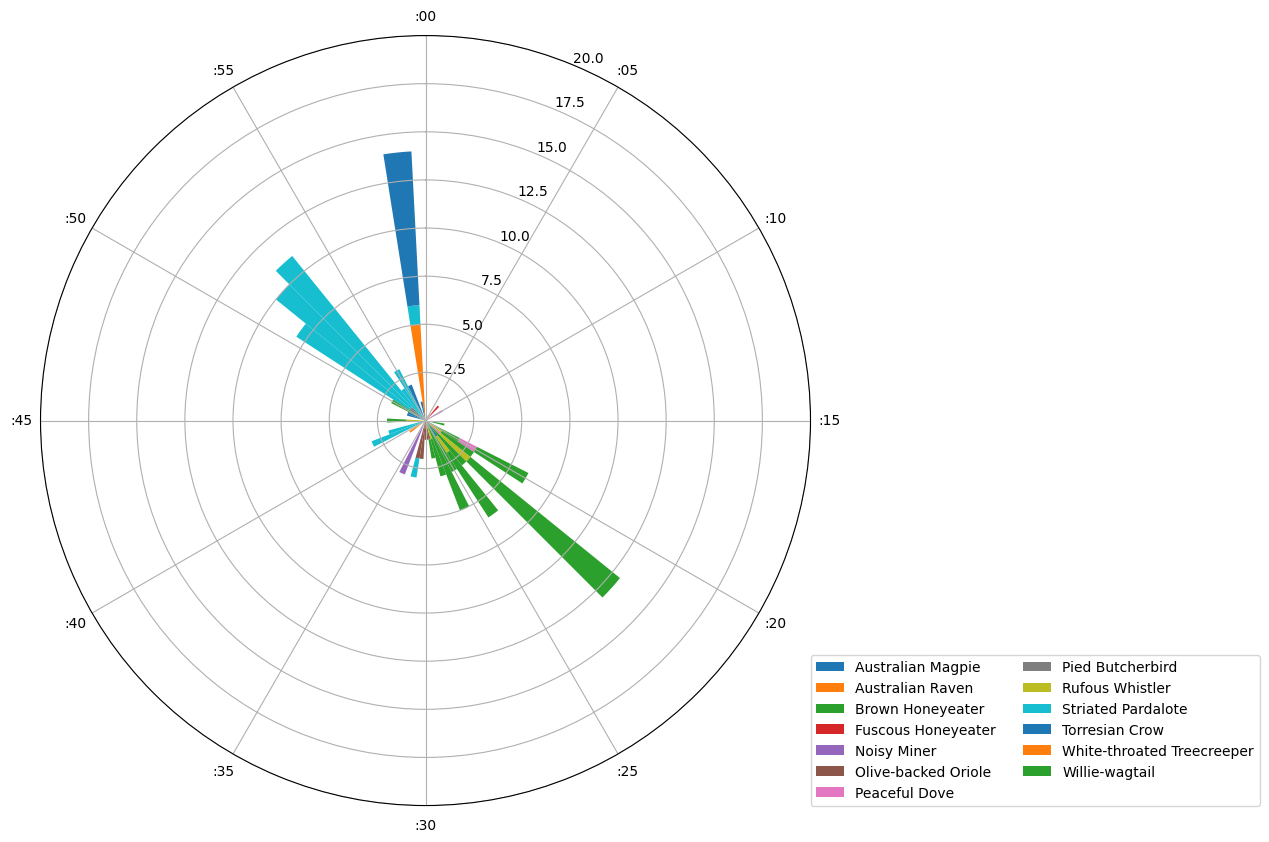

In [53]:
mintime = timestamp - timedelta(minutes=59)
df = raw.query('timestamp >= @mintime and timestamp <= @timestamp', engine='python')

species = df.common.unique()
species

# Count by minute
species_by_minute = (
    df
    .assign(moh=lambda r: r['timestamp'].dt.minute)
    .groupby(by=['common', 'moh'])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values(['moh', 'count'], ascending=[True, False])
)
# Transform and reorder
plotdf = (
    species_by_minute
    .groupby(['moh', 'common'])
    .sum()
    .unstack(level=-1)
    .fillna(0)
    .reindex([m for m in range(0, 60)], fill_value=0.0)
    .reset_index(drop=True)
)
plotdf.columns = plotdf.columns.get_level_values('common')


minutes = [m for m in range(0, 60)]
minutes_str = numpy.asarray([f":{_:02}" for _ in minutes if _ % 5 == 0])

N = len(minutes)
theta = numpy.linspace(0, 2*numpy.pi, N, endpoint=False)
width = numpy.pi * 2 / N

fig, ax = pyplot.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
# ax.set_title(title)
ax.set_theta_direction('clockwise')
ax.set_theta_zero_location('N')

for n, (c1, c2) in enumerate(zip(plotdf.columns[:-1], plotdf.columns[1:])):
    if n == 0:
        # first column only
        ax.bar(
            theta, plotdf[c1].values, 
            width=width,
            # color=palette[0],
            edgecolor='none',
            label=c1,
            linewidth=0
        )

    # all other columns
    ax.bar(
        theta, plotdf[c2].values, 
        width=width, 
        bottom=plotdf.cumsum(axis=1)[c1].values,
        # color=palette[n+1],
        edgecolor='none',
        label=c2,
        linewidth=0
    )

leg = ax.legend(loc=(1.0, 0), ncol=2)
if ax.get_ybound()[1] < 20:
    ax.set_ylim(0, 20)

ax.set_xticks([t for i, t in enumerate(theta) if i % 5 == 0])
xtl = ax.set_xticklabels(minutes_str)
# ax.annotate(max(raw.timestamp).strftime("%Y/%m/%d"), xy = (0, 0), xycoords='axes fraction')
